# LSLGA/DR9d QA

In [59]:
import os, glob
import fitsio
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import vstack, Table, hstack

In [60]:
import seaborn as sns
sns.set(context='talk', style='ticks', font_scale=1.2)
%matplotlib inline

In [61]:
outdir = '/global/project/projectdirs/desi/users/ioannis/dr9d-lslga'
if not os.path.isdir(outdir):
    os.makedirs(outdir, exist_ok=True)

In [62]:
#drdir = '/global/cscratch1/sd/dstn/dr9d2'
drdir = '/global/cscratch1/sd/ziyaoz/'
sweepdir = '/global/cscratch1/sd/desimpp/dr9d'

#### Read the reference LSLGA.

In [63]:
#lslgafile = '/global/project/projectdirs/cosmo/staging/largegalaxies/v2.0/LSLGA-v2.0.kd.fits'
lslgafile = os.getenv('LARGEGALAXIES_CAT')
lslga = Table(fitsio.read(lslgafile))
print('Read {} galaxies from {}'.format(len(lslga), lslgafile))
#lslga

Read 50923 galaxies from /global/project/projectdirs/cosmo/staging/largegalaxies/v4.0/LSLGA-v4.0.kd.fits


#### Get the set of completed bricks.

In [64]:
#bricks = glob.glob(os.path.join(drdir, 'tractor', '???', '*.fits'))
#tractor = vstack([Table(fitsio.read(catfile)) for catfile in bricks])
#bricks

In [68]:
def match_tractor_lslga(northsouth='south', overwrite=False):
    """Match to all the LSLGA galaxies and also gather 
    all the Sersic galaxies.
    
    """
    cols = ['RA', 'DEC', 'TYPE', 'BRICKNAME', 'REF_CAT', 
            'SERSIC', 'SHAPE_R', 'SHAPE_E1', 'SHAPE_E2', 
            'FLUX_R', 'REF_ID']

    outfile = os.path.join(outdir, 'dr9d-lslga-{}.fits'.format(northsouth))
    outfile_sersic = os.path.join(outdir, 'dr9d-sersic-{}.fits'.format(northsouth))
    if not os.path.isfile(outfile) or not os.path.isfile(outfile_sersic) or overwrite:
        out, outsersic = [], []
        catfile = glob.glob(os.path.join(sweepdir, northsouth, 'sweep', 'sweep-*.fits'))
        #catfile = glob.glob(os.path.join(drdir, 'dr9d-{}'.format(northsouth), 'tractor', '???', 'tractor*.fits'))
        if len(catfile) == 0:
            print('No catalogs found!')
            return
        #for ii, ff in enumerate(catfile[:2]):
        for ii, ff in enumerate(catfile):
            if ii % 50 == 0:
                print('{} / {}'.format(ii, len(catfile)))
            #import pdb ; pdb.set_trace()
            cc = fitsio.read(ff, columns=cols, upper=True)
            ckeep = np.where(cc['REF_CAT'] == b'L4')[0]
            if len(ckeep) > 0:
                out.append(Table(cc[ckeep]))
            skeep = np.where(cc['TYPE'] == b'SER')[0]
            if len(skeep) > 0:
                outsersic.append(Table(cc[skeep]))
        if len(out) == 0:
            print('No large galaxies!')
            return
        if len(outsersic) == 0:
            print('No Sersic galaxies!')
        else:
            outsersic = vstack(outsersic)
            print('Writing {} galaxies to {}'.format(len(outsersic), outfile_sersic))
            outsersic.write(outfile_sersic, overwrite=True)
            
        out = vstack(out)
        
        # find and remove duplicates
        #uval, cnt = np.unique(out['REF_ID'], return_counts=True)
        #dup_refid = uval[cnt > 1]

        # now match against the LSLGA
        #import pdb ; pdb.set_trace()
        match = [np.where(refid == lslga['LSLGA_ID'])[0] for refid in out['REF_ID']]
        if len(match) == 0:
            print('No matching large galaxies!')
            return
        match = np.hstack(match)
        
        lss = lslga[match]
        lss.rename_column('RA', 'RA_LSLGA')
        lss.rename_column('DEC', 'DEC_LSLGA')
        lss.rename_column('TYPE', 'MORPHTYPE')

        out = hstack((lss, out))
        
        print('Writing {} galaxies to {}'.format(len(out), outfile))
        out.write(outfile, overwrite=True)
    else:
        out = Table(fitsio.read(outfile))
        print('Read {} galaxies from {}'.format(len(out), outfile))

        outsersic = Table(fitsio.read(outfile_sersic))
        print('Read {} galaxies from {}'.format(len(outsersic), outfile_sersic))
    return out, outsersic

In [69]:
%time south, sersouth = match_tractor_lslga(northsouth='south', overwrite=False)

Read 758 galaxies from /global/project/projectdirs/desi/users/ioannis/dr9d-lslga/dr9d-lslga-south.fits
Read 284702 galaxies from /global/project/projectdirs/desi/users/ioannis/dr9d-lslga/dr9d-sersic-south.fits
CPU times: user 83 ms, sys: 4.15 ms, total: 87.1 ms
Wall time: 93.1 ms


In [70]:
%time north, sernorth = match_tractor_lslga(northsouth='north', overwrite=False)

Read 455 galaxies from /global/project/projectdirs/desi/users/ioannis/dr9d-lslga/dr9d-lslga-north.fits
Read 118360 galaxies from /global/project/projectdirs/desi/users/ioannis/dr9d-lslga/dr9d-sersic-north.fits
CPU times: user 30.1 ms, sys: 7.79 ms, total: 37.9 ms
Wall time: 36 ms


### Make some plots!

In [73]:
def qa_sersic(allcat, label):
    fig, ax = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
    for cat, lab, thisax in zip(allcat, label, ax.flat):
        ww = cat['FLUX_R'] > 0
        r50 = cat['SHAPE_R'][ww]
        sersicn = cat['SERSIC'][ww]
        rmag = 22.5-2.5*np.log10(cat['FLUX_R'][ww])
        thisax.scatter(rmag, sersicn, s=1, alpha=0.7)
        thisax.set_xlim(15, 23)
        thisax.set_xlabel(r'$r$ (AB mag)')
        thisax.set_title(lab)
    ax[0].set_ylabel('Sersic $n$')
    plt.subplots_adjust(wspace=0.1)

    fig, ax = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
    for cat, lab, thisax in zip(allcat, label, ax.flat):
        ww = cat['FLUX_R'] > 0
        r50 = cat['SHAPE_R'][ww]
        sersicn = cat['SERSIC'][ww]
        rmag = 22.5-2.5*np.log10(cat['FLUX_R'][ww])
        thisax.scatter(np.log10(r50), sersicn, s=1, alpha=0.7)
        thisax.set_xlim(-1, 2)
        thisax.set_xlabel(r'$\log_{10}\ r_{50}$ (arcsec)')
        thisax.set_title(lab)
    ax[0].set_ylabel('Sersic $n$')
    plt.subplots_adjust(wspace=0.1)

    fig, ax = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
    for cat, lab, thisax in zip(allcat, label, ax.flat):
        ww = cat['FLUX_R'] > 0
        r50 = cat['SHAPE_R'][ww]
        sersicn = cat['SERSIC'][ww]
        rmag = 22.5-2.5*np.log10(cat['FLUX_R'][ww])
        _ = thisax.hist(sersicn[sersicn > 1], bins=50)#, range=(1, 4))    
        thisax.set_yscale('log')
        thisax.set_xlabel('Sersic $n$')
        thisax.set_title(lab)
    ax[0].set_ylabel('Number of Galaxies')
    plt.subplots_adjust(wspace=0.1)

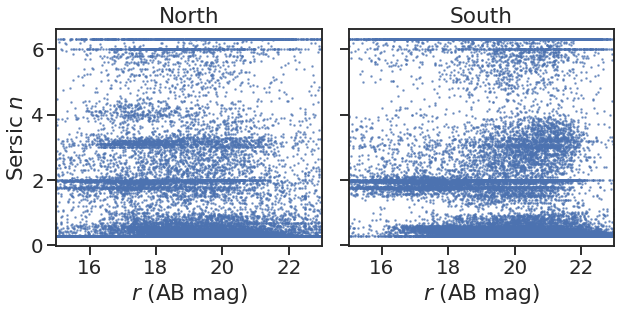

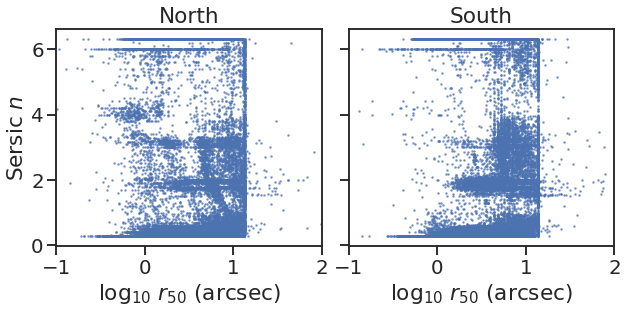

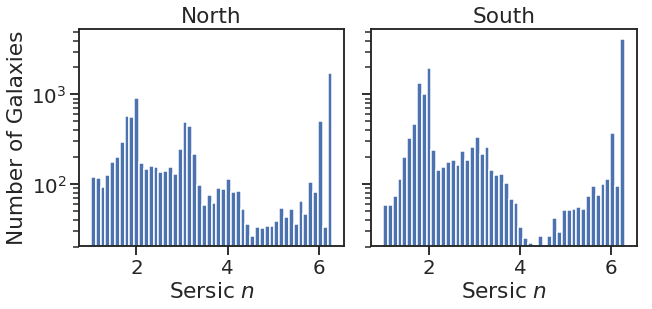

In [74]:
qa_sersic((sernorth, sersouth), ('North', 'South'))

In [75]:
def qa_radec(north, south, png=None):
    south_dra, south_ddec = (south['RA'] - south['RA_LSLGA']).data * 3600, (south['DEC'] - south['DEC_LSLGA']).data * 3600
    north_dra, north_ddec = (north['RA'] - north['RA_LSLGA']).data * 3600, (north['DEC'] - north['DEC_LSLGA']).data * 3600

    #print(np.median(dra), np.std(dra), np.median(ddec), np.std(ddec))
    fig, ax = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
    ax[0].scatter(south_dra, south_ddec, s=50)
    ax.scatter(north_dra, south_ddec, s=50)
    
    ax.set_xlim(-40, 40)
    ax.set_ylim(-40, 40)
    ax.axhline(y=0, ls='-', alpha=0.8, color='k')
    ax.axvline(x=0, ls='-', alpha=0.8, color='k')
    ax.set_xlabel(r'$\Delta\,$(RA) (arcsec)')
    ax.set_ylabel(r'$\Delta\,$(Dec) (arcsec)')
    plt.subplots_adjust(bottom=0.15, left=0.15)
    
    if png:
        pngfile = os.path.join(outdir, png)
        print('Writing {}'.format(pngfile))
        fig.savefig(pngfile)

-0.02077711980064123 2.956217656596477 -0.000430766296233287 1.4826008965656474


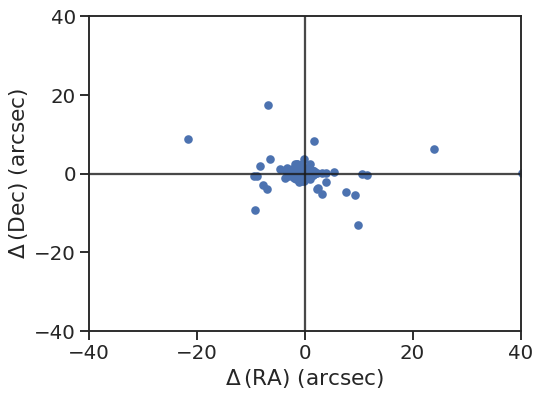

In [76]:
qa_radec(north)

In [ ]:
ww = tractor['type'] == 'SER'
r50, sersicn, rmag = tractor[ww]['shape_r'], tractor[ww]['sersic'], 22.5-2.5*np.log10(tractor[ww]['flux_r'])

In [ ]:
plt.scatter(np.log10(r50), sersicn, s=25)

In [ ]:
plt.scatter(np.log10(r50), rmag, s=25)

In [ ]:
plt.scatter(sersicn, rmag, s=25)

In [ ]:
_ = plt.hist(sersicn, bins=50, range=(0, 1))

#### Read the reference LSLGA.

In [ ]:
lslgafile = os.getenv('LARGEGALAXIES_CAT')
lslga = Table(fitsio.read(lslgafile))
print('Read {} galaxies from {}'.format(len(lslga), lslgafile))
lslga

In [ ]:
cut = lslga['IN_DESI'] * (lslga['D25'] > 1.5)
len(lslga[cut]) * 7 / 14000

### Maskbits statistics from the randoms.

The randoms are sampled at 5000/deg.

In [ ]:
MASKBITS = dict(
    NPRIMARY   = 0x1,   # not PRIMARY
    BRIGHT     = 0x2,
    SATUR_G    = 0x4,
    SATUR_R    = 0x8,
    SATUR_Z    = 0x10,
    ALLMASK_G  = 0x20,
    ALLMASK_R  = 0x40,
    ALLMASK_Z  = 0x80,
    WISEM1     = 0x100, # WISE masked
    WISEM2     = 0x200,
    BAILOUT    = 0x400, # bailed out of processing
    MEDIUM     = 0x800, # medium-bright star
    GALAXY     = 0x1000, # LSLGA large galaxy
    CLUSTER    = 0x2000, # Cluster catalog source
)

In [ ]:
randomfile = os.path.join(outdir, 'randoms-inside-dr8-0.31.0-1.fits')
ff = fitsio.FITS(randomfile)
nrows = ff[1].get_nrows()
nrand = 10000000
factor = nrows / nrand / 5000
%time rand = ff[1].read(rows=np.arange(nrand))
print('Read {}/{} random positions from {}'.format(len(rand), nrows, randomfile))

In [ ]:
print(rand.dtype)

In [ ]:
infoot = (rand['NOBS_G'] > 0) * (rand['NOBS_R'] > 0) * (rand['NOBS_Z'] > 0) * ((rand['MASKBITS'] & MASKBITS['NPRIMARY']) == 0)

In [ ]:
totarea = np.sum(infoot) * factor
print('Total area = {:.3f}'.format(totarea))
for bit in MASKBITS.keys():
    area = np.sum(infoot * ((rand['MASKBITS'] & MASKBITS[bit]) != 0) * factor)
    frac = 100 * area / totarea
    print('  {}: {:.3f} deg2, {:.3f}%'.format(bit, area, frac))

### LSLGA input/output fitting results.

In [ ]:
def read_dr8_lslga(region='north', clobber=False):
    sweepdir = '/global/project/projectdirs/cosmo/work/legacysurvey/dr8/{}/sweep/8.0/'.format(region)
    
    outfile = os.path.join(outdir, 'dr8-lslga-{}.fits'.format(region))
    if os.path.isfile(outfile) and not clobber:
        print('Reading {}'.format(outfile))
        out = Table.read(outfile)
    else:
        out = []
        catfile = glob(os.path.join(sweepdir, 'sweep*.fits'))
        for ii, ff in enumerate(catfile):
            if ii % 50 == 0:
                print('{} / {}'.format(ii, len(catfile)))
            cc = Table(fitsio.read(ff, columns=['REF_CAT', 'REF_ID', 'RA', 'DEC', 'TYPE', 'FRACDEV',
                                                'SHAPEEXP_R', 'SHAPEEXP_E1', 'SHAPEEXP_E2', 
                                                'SHAPEDEV_R', 'SHAPEDEV_E1', 'SHAPEDEV_E2'], upper=True))
            ckeep = np.where(cc['REF_CAT'] == 'L2')[0]
            #keep = np.where([rcat.decode('utf-8').strip() == 'L2' for rcat in cc['REF_CAT']])[0]
            if len(ckeep) > 0:
                cc = cc[ckeep]
                cc = cc[np.argsort(cc['REF_ID'])] # sort!
                _, uu = np.unique(cc['REF_ID'], return_index=True)
                if len(uu) != len(cc):
                    print('Duplicate large galaxy in {}'.format(os.path.basename(ff)))
                    cc = cc[uu]
                lkeep = np.where(np.isin(lslga['LSLGA_ID'], cc['REF_ID']))[0]
                if len(lkeep) != len(cc):
                    print('Still a problem with duplicates!')
                lss = lslga[lkeep]
                assert(np.all(lss['LSLGA_ID'] == cc['REF_ID']))
                lss.rename_column('RA', 'RA_LSLGA')
                lss.rename_column('DEC', 'DEC_LSLGA')
                lss.rename_column('TYPE', 'MORPHTYPE')
                out.append(hstack((lss, cc)))
                #import pdb ; pdb.set_trace()
        out = vstack(out)
        out.write(outfile, overwrite=True)
    return out

In [ ]:
%time north = read_dr8_lslga(region='north', clobber=False)
%time south = read_dr8_lslga(region='south', clobber=False)

In [ ]:
cat = vstack((north, south))
print('Read {} large galaxies.'.format(len(cat)))
cat[:5]

In [ ]:
def qa_radec(png=None):
    dra, ddec = (cat['RA'] - cat['RA_LSLGA']).data * 3600, (cat['DEC'] - cat['DEC_LSLGA']).data * 3600
    print(np.median(dra), np.std(dra), np.median(ddec), np.std(ddec))
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.scatter(dra, ddec, s=50)
    ax.set_xlim(-40, 40)
    ax.set_ylim(-40, 40)
    ax.axhline(y=0, ls='-', alpha=0.8, color='k')
    ax.axvline(x=0, ls='-', alpha=0.8, color='k')
    ax.set_xlabel(r'$\Delta\,$(RA) (arcsec)')
    ax.set_ylabel(r'$\Delta\,$(Dec) (arcsec)')
    plt.subplots_adjust(bottom=0.15, left=0.15)
    if png:
        pngfile = os.path.join(outdir, png)
        print('Writing {}'.format(pngfile))
        fig.savefig(pngfile)

In [ ]:
qa_radec(png='qa-radec.png')

In [ ]:
def get_e1e2(ba, phi):
    ab = 1. / ba
    e = (ab - 1) / (ab + 1)
    ee = -np.log(1 - e)
    angle = np.deg2rad(2. * (-phi))
    ee1 = ee * np.cos(angle)
    ee2 = ee * np.sin(angle)
    return ee1, ee2
        
def type2properties(cat, objtype):
    this = np.where([objtype == tt.strip() for tt in cat['TYPE']])[0]
    if objtype == 'EXP' or objtype == 'REX':
        reff, e1, e2 = cat['SHAPEEXP_R'][this], cat['SHAPEEXP_E1'][this], cat['SHAPEEXP_E2'][this]
    elif objtype == 'DEV':
        reff, e1, e2 = cat['SHAPEDEV_R'][this], cat['SHAPEDEV_E1'][this], cat['SHAPEDEV_E2'][this]
        
    lslga_rad = cat['D25'][this] / 2 * 60 / 2 # [arcmin]
    lslga_e1, lslga_e2 = get_e1e2(cat['BA'][this], 180-cat['PA'][this])
        
    return reff, e1, e2, lslga_rad, lslga_e1, lslga_e2, cat[this]

In [ ]:
def qa_morph(png=None):
    fig, ax = plt.subplots(1, 3, figsize=(18, 5))
    #for objtype in ('COMP', 'DEV', 'EXP', 'PSF', 'REX'):
    for objtype, marker in zip(('DEV', 'EXP', 'REX'), ('s', 'o', '*')):
        reff, e1, e2, lslga_rad, lslga_e1, lslga_e2, _ = type2properties(cat, objtype)
        ax[0].scatter(reff, lslga_rad, label=objtype, s=20, alpha=0.7, marker=marker)
        if objtype != 'REX':
            ax[1].scatter(e1, lslga_e1, s=20, alpha=0.7, marker=marker)
            ax[2].scatter(e2, lslga_e2, s=20, alpha=0.7, marker=marker)
    ax[0].set_xlim(0, 40)
    ax[0].set_ylim(0, 40)
    ax[0].axhline(y=5, color='k')
    ax[0].set_xlabel(r'r$_{eff}$ (Tractor, arcsec)')
    ax[0].set_ylabel(r'0.5 * R(25) (LSLGA, arcsec)')
    ax[1].set_xlabel(r'e$_1$ (Tractor)')
    ax[1].set_ylabel(r'e$_1$ (LSLGA)')
    ax[2].set_xlabel(r'e$_2$ (Tractor)')
    ax[2].set_ylabel(r'e$_2$ (LSLGA)')
    for xx in ax[1:]:
        xx.set_xlim(-1, 1)
        xx.set_ylim(-1, 1)
    leg = ax[0].legend(loc='upper left', frameon=True, fontsize=16, markerscale=2)
    for l in leg.get_lines():
        l.set_alpha(1)
    for xx in ax:
        xx.plot(xx.get_xlim(), xx.get_ylim(), color='k', ls='--')
    plt.subplots_adjust(wspace=0.35, bottom=0.2)
    if png:
        pngfile = os.path.join(outdir, png)
        print('Writing {}'.format(pngfile))
        fig.savefig(pngfile)    

In [ ]:
qa_morph(png='qa-lslga-morph.png')

In [ ]:
def qa_maskbits(png=None):
    from astropy.io import fits
    from astropy.visualization import AsinhStretch as Stretch
    from astropy.visualization import ImageNormalize
    from astropy.visualization import ZScaleInterval as Interval
    from astrometry.util.util import Tan
     
    brick = '1940p412'
    imgfile = os.path.join(outdir, 'legacysurvey-{}-image-r.fits.fz'.format(brick))
    img = fitsio.read(imgfile)
    msk = fitsio.read(os.path.join(outdir, 'legacysurvey-{}-maskbits.fits.fz'.format(brick)))
    hdr = fits.getheader(imgfile, ext=1)
    wcs = Tan(hdr['CRVAL1'], hdr['CRVAL2'], hdr['CRPIX1'], hdr['CRPIX2'], hdr['CD1_1'], 
              hdr['CD1_2'], hdr['CD2_1'], hdr['CD2_2'], hdr['NAXIS1'], hdr['NAXIS2'])
        
    cmap = plt.cm.viridis
    stretch = Stretch(a=0.9)
    interval = Interval(contrast=0.5, nsamples=10000)
    norm = ImageNormalize(img, interval=interval, stretch=stretch)
       
    inchperax = 4
    fig, ax = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(inchperax*3, 3))
    ax[0].imshow(img, origin='lower', norm=norm, cmap=cmap, interpolation='none')
    ax[1].imshow((msk & 2**12) != 0, origin='lower', interpolation='none')
    ax[2].imshow((msk & 2**1) != 0, origin='lower', interpolation='none')
    for xx in ax:
        xx.get_xaxis().set_visible(False)
        xx.get_yaxis().set_visible(False)
        xx.set_aspect('equal')
        xx.axis('off')
        xx.autoscale(False)
    fig.subplots_adjust(wspace=0)
    plt.tight_layout(w_pad=0)
    
    if png:
        pngfile = os.path.join(outdir, png)
        print('Writing {}'.format(pngfile))
        fig.savefig(pngfile, bbox_inches='tight')#, pad_inches=0)

In [ ]:
def qa_PGC3087924(png=None):
    from astropy.io import fits
    from astropy.visualization import AsinhStretch as Stretch
    from astropy.visualization import ImageNormalize
    from astropy.visualization import ZScaleInterval as Interval
    from astrometry.util.util import Tan
     
    brick = '1940p412'
    imgfile = os.path.join(outdir, 'legacysurvey-{}-image-r.fits.fz'.format(brick))
    img = fitsio.read(imgfile)
    msk = fitsio.read(os.path.join(outdir, 'legacysurvey-{}-maskbits.fits.fz'.format(brick)))
    hdr = fits.getheader(imgfile, ext=1)
    wcs = Tan(hdr['CRVAL1'], hdr['CRVAL2'], hdr['CRPIX1'], hdr['CRPIX2'], hdr['CD1_1'], 
              hdr['CD1_2'], hdr['CD2_1'], hdr['CD2_2'], hdr['NAXIS1'], hdr['NAXIS2'])
    
    cmap = plt.cm.viridis
    stretch = Stretch(a=0.9)
    interval = Interval(contrast=0.5, nsamples=10000)
    norm = ImageNormalize(img, interval=interval, stretch=stretch)
       
    rad = 250
    _, x0, y0 = wcs.radec2pixelxy(194.0090, 41.2926)
    x0, y0 = np.int(x0), np.int(y0)
    imgcut = img[y0-rad:y0+rad, x0-rad:x0+rad]
    mskcut = msk[y0-rad:y0+rad, x0-rad:x0+rad]
    
    fig, ax = plt.subplots()
    #ax.imshow(imgcut, origin='lower', norm=norm, cmap=cmap, interpolation='none')
    ax.imshow(mskcut, origin='lower')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_aspect('equal')
    ax.axis('off')
    ax.autoscale(False)
    fig.subplots_adjust(wspace=0)
    plt.tight_layout(w_pad=0)
    
    if png:
        pngfile = os.path.join(outdir, png)
        print('Writing {}'.format(pngfile))
        fig.savefig(pngfile, bbox_inches='tight', pad_inches=0)

In [ ]:
qa_PGC3087924(png='PGC3087924-maskbits.jpg')

In [ ]:
qa_maskbits(png='qa-maskbits.png')

In [ ]:
stop

In [ ]:
reff, e1, e2, lslga_rad, lslga_e1, lslga_e2, devcat = type2properties(cat, 'DEV')
big = np.where(reff > 25)[0]
for cc in devcat[big][:20]:
    size = np.round(cc['D25'] * 1.5 * 60 / 0.262).astype(int)
    montagefile = 'montage/{}.jpg'.format(cc['GALAXY'].lower())
    jpgfile = []
    #print('http://legacysurvey.org/viewer-dev?ra={}&dec={}&zoom=14&layer=dr8b-decam&lslga'.format(cc['RA'], cc['DEC']))
    for ii, imtype in enumerate(('', '-model', '-resid')):
        jpgfile.append('jpg/{}{}.jpg'.format(cc['GALAXY'].lower(), imtype))
        url = '"http://legacysurvey.org/viewer-dev/jpeg-cutout?ra={}&dec={}&size={}&layer=dr8b-decam{}"'.format(
            cc['RA'], cc['DEC'], size, imtype)
        if not os.path.exists(jpgfile[ii]):
            cmd = 'wget --continue -O {} {}'.format(jpgfile[ii], url)
            print(cmd)
            os.system(cmd)
            time.sleep(1)
    cmd = 'montage -bordercolor white -borderwidth 1 -tile 3x1 -geometry +0+0 '
    cmd = cmd+' '.join(ff for ff in jpgfile)
    cmd = cmd+' {}'.format(montagefile)
    print(cmd)
    os.system(cmd)    